# Probabilistic Graphical Models - Homework 2, IWAE

MVA 2021-2022

Elías Masquil (eliasmasquil@gmail.com)

Nicolás Violante (nviolante96@gmail.com)

In this assignment, you'll play a bit with a VAE on a binarised version of MNIST

# Loading useful stuff

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions

# Loading MNIST and binarising it

In [ ]:
(train_images_nonbinary, y_train), (test_images_nonbinary,  y_test) = tf.keras.datasets.mnist.load_data()

train_images_nonbinary = train_images_nonbinary.reshape(train_images_nonbinary.shape[0], 28*28)
test_images_nonbinary = test_images_nonbinary.reshape(test_images_nonbinary.shape[0], 28*28)

y_train = tf.cast(y_train, tf.int64)
y_test =tf.cast(y_test, tf.int64)

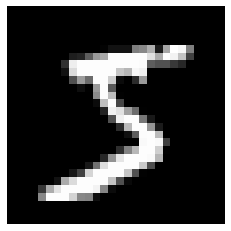

In [ ]:
plt.imshow(train_images_nonbinary[0, :].reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

Then we binarise the data. There are many ways to do that. Here, we simply round the numbers, following the [TF tutorial on convolutional VAEs](https://www.tensorflow.org/tutorials/generative/cvae).

In [ ]:
# Normalizing the images to the range of [0., 1.]
train_images = train_images_nonbinary/255.
test_images = test_images_nonbinary/255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

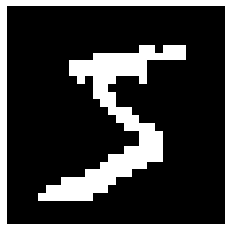

In [ ]:
plt.imshow(train_images[0, :].reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

# Specifying our graphical model

We will use a **deep latent variable model with a Gaussian prior and a Bernoulli observation model**. This can be written:

$$p_{\boldsymbol{\theta}}(\mathbf{x}_1,...,\mathbf{x}_n) = \prod_{i=1}^n p(\mathbf{x}_i|\mathbf{z}_i)p(\mathbf{z}_i),$$
$$p(\mathbf{z}_i) = \mathcal{N}(\mathbf{z}_i|\mathbf{0}_d,\mathbf{I}_d), $$
$$p_{\boldsymbol{\theta}}(\mathbf{x}_i|\mathbf{z}_i) = \mathcal{B} (\mathbf{x}_i|\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}_i)),$$

where $\boldsymbol{\pi}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{[0,1]}^p$ is a function (called the **decoder**) parametrised by a deep neural net. This neural net will be defined as a keras sequential model.

In [ ]:
d = 10 # dimension of the latent space

p_z = tfd.Independent(tfd.Normal(loc = tf.zeros(d, tf.float32), scale = tf.ones(d, tf.float32)),reinterpreted_batch_ndims=1)  # that's the prior

In [ ]:
h = 100 # number of hidden units

sigma = "relu"

decoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[d,]),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(28*28)
])

Note that the decoder needs to output probabilities, which can be constrained using a sigmoid final layer. However, it is generally better (i.e. computationnaly more stable) to work with [logits](https://stackoverflow.com/questions/34240703/what-are-logits-what-is-the-difference-between-softmax-and-softmax-cross-entrop) than probabilities, when doing deep learning. For instance, all the distributions of TensorFlow probability or Pytorch distributions that use probabilities as parameters (e.g. [Bernoulli](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Bernoulli), [categorical](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Categorical) or [binomial](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Binomial)) can use $\texttt{logits}$ or $\texttt{probs}$ as arguments. It is generally better to use  $\texttt{logits}$. This is why this keras model for the decoder does not output probabilities, but logits.





**1. Implement a function that performs ancestral sampling for this deep latent variable model, and show 5 sampled images from the initialised model. Of course, we expect these samples to look like random noise, since we have not trained our model yet.**

## Ex 1. Ancestral sampling

In [ ]:
def ancestral_sampling(decoder, p_z, num_samples=5):
    z = p_z.sample(num_samples)
    pi_z = decoder(z)
    p_theta = tfd.Independent(tfd.Bernoulli(logits=pi_z), reinterpreted_batch_ndims=1)
    images = p_theta.sample()    
    for i in range(num_samples):
        img = tf.reshape(images[i], (28,28))
        plt.figure()
        plt.imshow(img, cmap="gray")

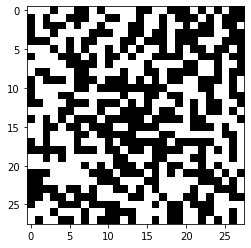

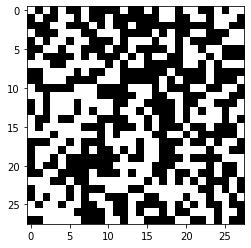

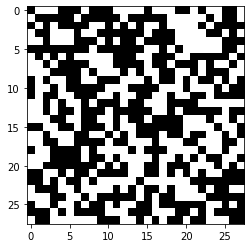

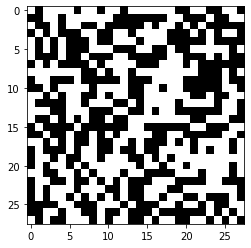

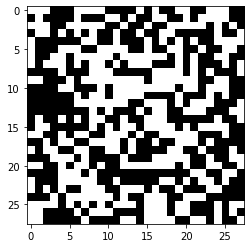

In [ ]:
ancestral_sampling(decoder, p_z)

## Encoder

To be able to train our model, we will need an **encoder** (aka **inference network**), that will allow us to approximate the intractable posterior $p(\mathbf{z}|\mathbf{x})$.
The approximate posterior is defined as follows
$$ q(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mathbf{z} | \mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x} ), \text{Diag}(\mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x} )),
$$ 
where $\mathbf{x} \mapsto (\mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x} ), \mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x} ))$ is a function from the data space (i.e. $\{0,1\}^p$) to $\mathbb{R}^d \times [0, \infty[^d$ parametrised by a deep neural network. In other words, the encoder outputs the mean and the diagonal of the covariance matrix of the approximate posterior $q(\mathbf{z}|\mathbf{x})$.

In [ ]:
encoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[28*28,]),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(2*d) # 2*d because we need both the mean and the diagonal of the covariance of q(z|x)
])

##The IWAE objective

The **IWAE objective** is defined as
$$
\mathcal{L}_K (\boldsymbol{\theta,\gamma}) = \sum_{i=1}^n \mathbb{E}_{\mathbf{z}_{i1},\ldots,\mathbf{z}_{iK} \sim q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}_i)} \left[ \log\frac{1}{K} \sum_{k=1}^K \frac{p_{\boldsymbol{\theta}}(\mathbf{x}_i|\mathbf{z}_{ik}){p(\mathbf{z}_{ik})}}{{q_{\boldsymbol{\gamma}}(\mathbf{z}_{ik}|\mathbf{x}_i)}} \right]
$$

**2. Create a function that computes an unbiased estimate of the IWAE bound, and optimise it to train the model. You are allowed to use TF probability to avoid implementing the reparametrisation trick, and you are allowed to use keras for training.** 

**3. Show a few samples from the model after training.**






In [ ]:
class VAE(tfk.Model):
    """Variational autoencoder trained by maximizing IWAE bound"""


    def __init__(self, encoder, decoder, p_z, k=5, d=10):
        """
        encoder: neural network
        decoder: neural network
        k: number of montecarlo samples for the estimate of the likelihood
        d: dimension of the latent space
        p_z: prior distribution on the latent space
        """
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.k = k
        self.d = d
        self.p_z = p_z


    def compute_loss(self, X):
        """
        Computes the loss in the log-domain by using logsumexp to avoid
        numerical instability
        """

        batch_size = X.shape[0]
        # Encode the data and get latent distribution parameters
        parameters_q = self.encoder(X)
        means_q = parameters_q[:,:self.d]
        covs_q = tf.nn.softplus(parameters_q[:, self.d:])

        # Compute latent distribution and sample from it
        q_z = tfd.Independent(tfd.Normal(loc=means_q, scale=covs_q), reinterpreted_batch_ndims=1)
        
        # Sample code (k samples for MC estimate)
        z = q_z.sample(self.k)
        prob_q_z = q_z.log_prob(z)

        # Compute reconstructed image (decoder part)
        # Evaluate prior on the codes
        prob_z = p_z.log_prob(z)
        # Merge batch and K dimension before feeding it to the decoder (because we have k samples for each image)
        # Then, revert this change to have K estimates for each image
        # pi_z are Bernoulli parameters obtained with the decoder
        pi_z = tf.reshape(self.decoder(tf.reshape(z, (batch_size*self.k, self.d))), (self.k, batch_size, -1))
        # Posterior distribution
        p_theta = tfd.Independent(tfd.Bernoulli(logits=pi_z), reinterpreted_batch_ndims=1)
        prob_theta = p_theta.log_prob(X)
        
        # IWAE loss (- IWAE bound)
        return - tf.math.reduce_mean(tf.reduce_logsumexp(prob_theta + prob_z - prob_q_z,0))


    def train_step(self, X):
        """
        Tensorflow training step. Backpropagation of the gradients and optimizer step
        """
        with tf.GradientTape() as tape:
            loss = self.compute_loss(X)
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": loss}


## Ex 2. Training the IWAE

In [ ]:
vae = VAE(encoder, decoder, p_z)
vae.compile(optimizer=tfk.optimizers.Adam())
vae.fit(train_images, epochs=50, batch_size=32)

Epoch 1/50
1875/1875 [==============================] - 9s 4ms/step - loss: 89.5706
Epoch 2/50
1875/1875 [==============================] - 8s 4ms/step - loss: 89.3599
Epoch 3/50
1875/1875 [==============================] - 8s 4ms/step - loss: 89.1284
Epoch 4/50
1875/1875 [==============================] - 8s 4ms/step - loss: 88.9523
Epoch 5/50
1875/1875 [==============================] - 8s 4ms/step - loss: 88.8214
Epoch 6/50
1875/1875 [==============================] - 8s 4ms/step - loss: 88.6917
Epoch 7/50
1875/1875 [==============================] - 8s 4ms/step - loss: 88.4780
Epoch 8/50
1875/1875 [==============================] - 8s 4ms/step - loss: 88.3569
Epoch 9/50
1875/1875 [==============================] - 8s 4ms/step - loss: 88.2146
Epoch 10/50
1875/1875 [==============================] - 8s 4ms/step - loss: 88.1084
Epoch 11/50
1875/1875 [==============================] - 8s 4ms/step - loss: 87.9520
Epoch 12/50
1875/1875 [==============================] - 8s 4ms/step - los

### IWAE bound

In [ ]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_images)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images)).batch(batch_size)

train_iwae = []
train_iwae = tf.reduce_mean([-vae.compute_loss(images) for images in train_dataset])

test_iwae = []
test_iwae = tf.reduce_mean([-vae.compute_loss(images) for images in test_dataset])

print(f"IWAE bound in train: {train_iwae}")
print(f"IWAE bound in test: {test_iwae}")

IWAE bound in train: -84.82263946533203
IWAE bound in test: -86.43109130859375


## Ex 3. Visualizing generated samples

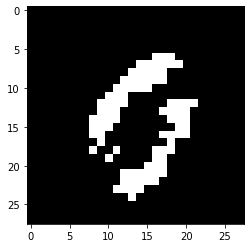

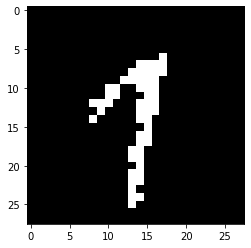

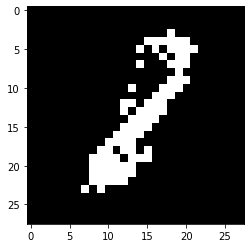

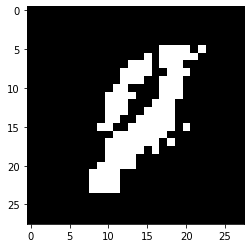

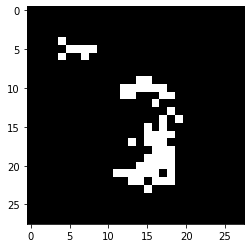

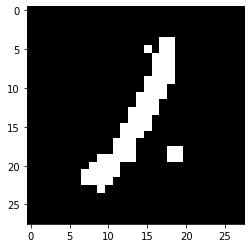

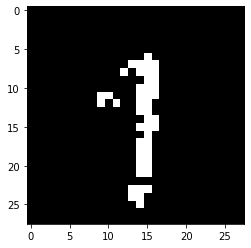

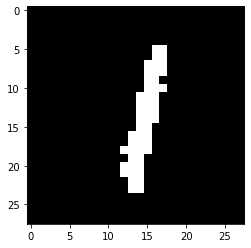

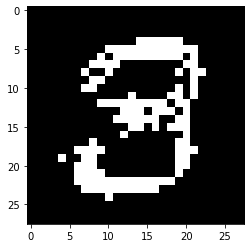

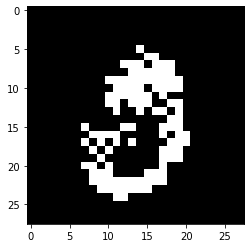

In [ ]:
ancestral_sampling(vae.decoder, vae.p_z, 10)

## Ex 4. Importance sampling and visualisation

In [ ]:
means = []
for batch_image in test_dataset:
    means.append(vae.encoder(batch_image)[:, :10].numpy())

means = np.vstack(means)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


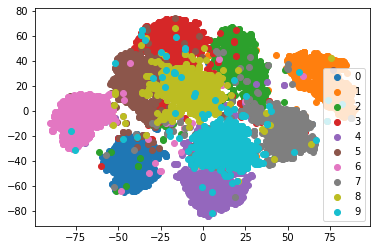

In [ ]:
from sklearn.manifold import TSNE
tnse = TSNE(2)
data = tnse.fit_transform(means)

fig, ax = plt.subplots()
groups = np.unique(y_test.numpy())
for group in groups:
    idx = np.where(y_test.numpy() == group)[0]
    d = data[idx, :]
    ax.scatter(d[:,0], d[:,1], label=group)
ax.legend()